In [2]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches
import numpy as np
import tensorflow as tf


import pandas as pd
import seaborn as sns
from sklearn import preprocessing

In [3]:
try:
    # enable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type == 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [4]:
DATA_DIR_SLOW = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaSlow.npy"
DATA_DIR_NORMAL = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaNormal.npy"
DATA_DIR_C_NAMES = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaColumnNames.npy"

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [5]:
data_normal = np.load(DATA_DIR_NORMAL)
data_slow = np.load(DATA_DIR_SLOW)
column_names = np.load(DATA_DIR_C_NAMES)

In [6]:
print(column_names)

['action' 'machine_nameKuka Robot_apparent_power'
 'machine_nameKuka Robot_current' 'machine_nameKuka Robot_frequency'
 'machine_nameKuka Robot_phase_angle' 'machine_nameKuka Robot_power'
 'machine_nameKuka Robot_power_factor'
 'machine_nameKuka Robot_reactive_power' 'machine_nameKuka Robot_voltage'
 'sensor_id1_AccX' 'sensor_id1_AccY' 'sensor_id1_AccZ' 'sensor_id1_GyroX'
 'sensor_id1_GyroY' 'sensor_id1_GyroZ' 'sensor_id1_q1' 'sensor_id1_q2'
 'sensor_id1_q3' 'sensor_id1_q4' 'sensor_id1_temp' 'sensor_id2_AccX'
 'sensor_id2_AccY' 'sensor_id2_AccZ' 'sensor_id2_GyroX' 'sensor_id2_GyroY'
 'sensor_id2_GyroZ' 'sensor_id2_q1' 'sensor_id2_q2' 'sensor_id2_q3'
 'sensor_id2_q4' 'sensor_id2_temp' 'sensor_id3_AccX' 'sensor_id3_AccY'
 'sensor_id3_AccZ' 'sensor_id3_GyroX' 'sensor_id3_GyroY'
 'sensor_id3_GyroZ' 'sensor_id3_q1' 'sensor_id3_q2' 'sensor_id3_q3'
 'sensor_id3_q4' 'sensor_id3_temp' 'sensor_id4_AccX' 'sensor_id4_AccY'
 'sensor_id4_AccZ' 'sensor_id4_GyroX' 'sensor_id4_GyroY'
 'sensor_id4_GyroZ

## Dataset Setup

In [7]:
# Get labels from data slow
label_slow = data_slow[:,-1:]
data_slow = data_slow[:,:-1]

In [8]:
# Normalization train on train set transform both
scaler = preprocessing.StandardScaler().fit(data_normal)
data_train_scaled = scaler.transform(data_normal)
data_test_scaled = scaler.transform(data_slow) #

In [9]:
#windows of 50 with stride 1
width_window = 50
data_train_all = np.array([data_train_scaled[i:i+width_window,:] for i in range(0, len(data_train_scaled)-width_window)])
data_test_all = np.array([data_test_scaled[i:i+width_window,:] for i in range(0, len(data_test_scaled)-width_window)])
print(f"train data shape: {data_train_all.shape} \n test data shape: {data_test_all.shape} ")

train data shape: (233742, 50, 86) 
 test data shape: (41488, 50, 86) 


In [10]:
percentage = 0.10
N = 2

# take part of data to gather results faster
data_train = data_train_all[0:int(percentage*data_train_all.shape[0]),:,:]
data_test = data_test_all[0:int(percentage*data_test_all.shape[0]),:,:]

# mixed test data 50-50
data_test_mixed = np.zeros((2*data_test.shape[0], data_test.shape[1], data_test.shape[2]))
data_test_mixed[0:int(data_test.shape[0]),:,:] += data_test
data_test_mixed[int(data_test.shape[0]):,:,:] += data_train[-int(data_test.shape[0]):,:,:]

# set labels
label_test = label_slow[0:data_test.shape[0]]
label_test_mixed = np.zeros((data_test_mixed.shape[0], 1))
label_test_mixed[0:label_test.shape[0]] += label_test

# Validation data
data_validation = data_train_all[int(percentage*data_train_all.shape[0]*N): int(percentage*data_train_all.shape[0]*(N+0.2)),:,:]


print(f"train data shape: {data_train.shape} \ntest data shape: {data_test.shape} \nlabel shape: {label_test.shape} \n\ntest data prepared: {data_test_mixed.shape} \nlabel prepared: {label_test_mixed.shape} \n\ndata validation: {data_validation.shape}")

train data shape: (23374, 50, 86) 
test data shape: (4148, 50, 86) 
label shape: (4148, 1) 

test data prepared: (8296, 50, 86) 
label prepared: (8296, 1) 

data validation: (4675, 50, 86)


In [11]:
# Run if you want ram to free
data_train_all = 0
data_train_all = 0

## Model

In [13]:
batch_size = 256
comment = False

train_dataset = tf.data.Dataset.from_tensor_slices(data_train)
train_dataset = train_dataset.batch(batch_size)

In [14]:
def make_encoder_model(z_size):
    inputs = tf.keras.layers.Input(shape=(50, 86))
    if comment is True : print(f"encoder input: {inputs.shape}")
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=7, strides=2, padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv1D(filters=256, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv1D(filters=256, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv1D(filters=256, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    z = tf.keras.layers.Conv1D(filters=z_size, kernel_size=7, strides=2, padding='same')(x)
    if comment is True : print(f"endoder output: {z.shape}")

    model = tf.keras.Model(inputs=inputs, outputs=z)
    return model

def make_decoder_model(z_size):
    encoded = tf.keras.Input(shape=(1, z_size))
    if comment is True : print(f"decoder input: {encoded.shape}")

    x = tf.keras.layers.Conv1D(256, kernel_size=7, padding='same', activation='relu')(encoded)
    x = tf.keras.layers.UpSampling1D(2)(x)
    x = tf.keras.layers.Conv1D(256, kernel_size=7, padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling1D(2)(x)
    x = tf.keras.layers.Conv1D(256, kernel_size=7, padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling1D(2)(x)
    x = tf.keras.layers.Conv1D(128, kernel_size=7, padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling1D(2)(x)
    x = tf.keras.layers.Conv1D(128, kernel_size=7, padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling1D(2)(x)
    x = tf.keras.layers.Conv1D(86, kernel_size=7, activation='relu')(x)
    x = tf.keras.layers.UpSampling1D(2)(x)

    reconstruction = tf.keras.layers.Conv1D(filters=86, kernel_size=3, activation='sigmoid')(x)
    if comment is True : print(f"decoder output: {reconstruction.shape}")
    decoder = tf.keras.Model(inputs=encoded, outputs=reconstruction)
    return decoder

def make_discriminator_model(z_size):
    encoded = tf.keras.Input(shape=(1, z_size))
    if comment is True : print(f"discriminator input: {encoded.shape}")
    x = tf.keras.layers.Dense(128)(encoded)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    prediction = tf.keras.layers.Dense(1)(x)
    if comment is True : print(f"discriminator output: {prediction.shape}")
    model = tf.keras.Model(inputs=encoded, outputs=prediction)
    return model

In [22]:
z_dim = 512
encoder = make_encoder_model(z_dim)
decoder = make_decoder_model(z_dim)
discriminator = make_discriminator_model(z_dim)

In [23]:
# Define loss functions
ae_loss_weight = 1.
gen_loss_weight = 1.
dc_loss_weight = 1.

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()
accuracy = tf.keras.metrics.BinaryAccuracy()

In [17]:
def autoencoder_loss(inputs, reconstruction, loss_weight):
    return loss_weight * mse(inputs, reconstruction)


def discriminator_loss(real_output, fake_output, loss_weight):
    loss_real = cross_entropy(tf.ones_like(real_output), real_output)
    loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return loss_weight * (loss_fake + loss_real)


def generator_loss(fake_output, loss_weight):
    return loss_weight * cross_entropy(tf.ones_like(fake_output), fake_output)

In [24]:
base_lr = 0.000001
max_lr = 0.00001

n_samples = data_train.shape[0]
step_size = 2 * np.ceil(n_samples / batch_size)
global_step = 0

In [25]:
ae_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
dc_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)

In [20]:
def train_step(batch_x):
    # -------------------------------------------------------------------------------------------------------------
    # Autoencoder
    with tf.GradientTape() as ae_tape:
        encoder_output = encoder(batch_x, training=True)
        decoder_output = decoder(encoder_output, training=True)

        if comment is True : print(f"Train step: \nbatch_x: {batch_x.shape}, decoder_output: {decoder_output.shape}")
        # Autoencoder loss
        ae_loss = autoencoder_loss(batch_x, decoder_output, ae_loss_weight)

    ae_grads = ae_tape.gradient(ae_loss, encoder.trainable_variables + decoder.trainable_variables)
    ae_optimizer.apply_gradients(zip(ae_grads, encoder.trainable_variables + decoder.trainable_variables))

    # -------------------------------------------------------------------------------------------------------------
    # Discriminator
    with tf.GradientTape() as dc_tape:
        real_distribution = tf.random.normal([batch_x.shape[0], 1, z_dim], mean=0.0, stddev=1.0)
        encoder_output = encoder(batch_x, training=True)

        dc_real = discriminator(real_distribution, training=True)
        dc_fake = discriminator(encoder_output, training=True)

        # Discriminator Loss
        dc_loss = discriminator_loss(dc_real, dc_fake, dc_loss_weight)

        # Discriminator Acc
        dc_acc = accuracy(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                          tf.concat([dc_real, dc_fake], axis=0))

    dc_grads = dc_tape.gradient(dc_loss, discriminator.trainable_variables)
    dc_optimizer.apply_gradients(zip(dc_grads, discriminator.trainable_variables))

    # -------------------------------------------------------------------------------------------------------------
    # Generator (Encoder)
    with tf.GradientTape() as gen_tape:
        encoder_output = encoder(batch_x, training=True)
        dc_fake = discriminator(encoder_output, training=True)

        # Generator loss
        gen_loss = generator_loss(dc_fake, gen_loss_weight)

    gen_grads = gen_tape.gradient(gen_loss, encoder.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grads, encoder.trainable_variables))

    return ae_loss, dc_loss, dc_acc, gen_loss

In [26]:
n_epochs = 100
train_autoencoder_loss = []
train_generator_loss = []
train_discriminator_loss = []
train_discriminator_acc = []

test_cost = []
validation_cost = []
for epoch in range(n_epochs):
    start = time.time()

    # Learning rate schedule
    if epoch in [60, 100, 300]:
        base_lr = base_lr / 2
        max_lr = max_lr / 2
        step_size = step_size / 2

        print('learning rate changed!')

    epoch_ae_loss_avg = tf.metrics.Mean()
    epoch_dc_loss_avg = tf.metrics.Mean()
    epoch_dc_acc_avg = tf.metrics.Mean()
    epoch_gen_loss_avg = tf.metrics.Mean()
    for batch, (batch_x) in enumerate(train_dataset):
        # -------------------------------------------------------------------------------------------------------------
        # Calculate cyclic learning rate
        global_step = global_step + 1
        cycle = np.floor(1 + global_step / (2 * step_size))
        x_lr = np.abs(global_step / step_size - 2 * cycle + 1)
        clr = base_lr + (max_lr - base_lr) * max(0, 1 - x_lr)
        ae_optimizer.lr = clr
        dc_optimizer.lr = clr
        gen_optimizer.lr = clr

        ae_loss, dc_loss, dc_acc, gen_loss = train_step(batch_x)

        epoch_ae_loss_avg(ae_loss)
        epoch_dc_loss_avg(dc_loss)
        epoch_dc_acc_avg(dc_acc)
        epoch_gen_loss_avg(gen_loss)

    epoch_time = time.time() - start
    print('{:4d}: TIME: {:.2f} ETA: {:.2f} AE_LOSS: {:.4f} DC_LOSS: {:.4f} DC_ACC: {:.4f} GEN_LOSS: {:.4f}' \
          .format(epoch+1, epoch_time,
                  epoch_time * (n_epochs - epoch),
                  epoch_ae_loss_avg.result(),
                  epoch_dc_loss_avg.result(),
                  epoch_dc_acc_avg.result(),
                  epoch_gen_loss_avg.result()))
    train_autoencoder_loss.append(epoch_ae_loss_avg.result())
    train_generator_loss.append(epoch_gen_loss_avg.result())
    train_discriminator_loss.append(epoch_dc_loss_avg.result())
    train_discriminator_acc.append(epoch_dc_acc_avg.result())

    # -------------------------------------------------------------------------------------------------------------
    test_decoded = decoder(encoder(data_test, training=False), training=False)
    cost_test = np.mean(np.abs(test_decoded - data_test), axis=1)
    test_cost.append(cost_test)
    print(f"Mean cost of test: {np.mean(cost_test)}")

    val_decoded = decoder(encoder(data_validation, training=False), training=False)
    cost_val = np.mean(np.abs(val_decoded - data_validation), axis=1)
    validation_cost.append(cost_val)
    print(f"Mean cost of validation: {np.mean(cost_val)}")
    """
    # -------------------------------------------------------------------------------------------------------------
    if epoch % 10 == 0:
        # Latent Space
        x_test_encoded = encoder(data_test, training=False)
        label_list = list(label_test)

        fig = plt.figure()
        classes = set(label_list)
        colormap = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
        kwargs = {'alpha': 0.8, 'c': [colormap[i] for i in label_list]}
        ax = plt.subplot(111, aspect='equal')
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        handles = [mpatches.Circle((0, 0), label=class_, color=colormap[i])
                   for i, class_ in enumerate(classes)]
        ax.legend(handles=handles, shadow=True, bbox_to_anchor=(1.05, 0.45),
                  fancybox=True, loc='center left')
        plt.scatter(x_test_encoded[:, :, :, 0], x_test_encoded[:, :, :, 1], s=2, **kwargs)
        ax.set_xlim([-3, 3])
        ax.set_ylim([-3, 3])

        #plt.savefig(latent_space_dir / ('epoch_%d.png' % epoch))
        plt.close('all')

        # Reconstruction
        n_digits = 20  # how many digits we will display
        x_test_decoded = decoder(encoder(data_test[:n_digits], training=False), training=False)
        x_test_decoded = np.reshape(x_test_decoded, [-1, 28, 28]) * 255
        fig = plt.figure(figsize=(20, 4))
        for i in range(n_digits):
            # display original
            ax = plt.subplot(2, n_digits, i + 1)
            plt.imshow(data_test[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(2, n_digits, i + 1 + n_digits)
            plt.imshow(x_test_decoded[i])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.savefig(reconstruction_dir / ('epoch_%d.png' % epoch))
        plt.close('all')

        # Sampling
        x_points = np.linspace(-3, 3, 20).astype(np.float32)
        y_points = np.linspace(-3, 3, 20).astype(np.float32)

        nx, ny = len(x_points), len(y_points)
        plt.subplot()
        gs = gridspec.GridSpec(nx, ny, hspace=0.05, wspace=0.05)

        for i, g in enumerate(gs):
            z = np.concatenate(([x_points[int(i / ny)]], [y_points[int(i % nx)]]))
            z = np.reshape(z, (1, 1, 1, 2))
            x = decoder(z, training=False).numpy()
            ax = plt.subplot(g)
            img = np.array(x.tolist()).reshape(28, 28)
            ax.imshow(img, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect('auto')
        plt.savefig(sampling_dir / ('epoch_%d.png' % epoch))
        plt.close('all')
    """


   1: TIME: 60.63 ETA: 6063.18 AE_LOSS: 1.4257 DC_LOSS: 1.5954 DC_ACC: 0.6305 GEN_LOSS: 0.3754
Mean cost of test: 0.740725576877594
Mean cost of validation: 0.7859328985214233
   2: TIME: 58.77 ETA: 5818.26 AE_LOSS: 1.3328 DC_LOSS: 3.1758 DC_ACC: 0.4694 GEN_LOSS: 0.0758
Mean cost of test: 0.6677078604698181
Mean cost of validation: 0.7268118262290955
   3: TIME: 60.03 ETA: 5883.04 AE_LOSS: 1.1446 DC_LOSS: 3.3890 DC_ACC: 0.4279 GEN_LOSS: 0.0544
Mean cost of test: 0.6200154423713684
Mean cost of validation: 0.6796141862869263
   4: TIME: 61.06 ETA: 5923.12 AE_LOSS: 1.0968 DC_LOSS: 3.2127 DC_ACC: 0.4063 GEN_LOSS: 0.0642
Mean cost of test: 0.6005900502204895
Mean cost of validation: 0.6615731120109558
   5: TIME: 60.51 ETA: 5809.13 AE_LOSS: 1.0779 DC_LOSS: 3.1639 DC_ACC: 0.3932 GEN_LOSS: 0.0675
Mean cost of test: 0.5873546004295349
Mean cost of validation: 0.649929404258728
   6: TIME: 58.91 ETA: 5596.63 AE_LOSS: 1.0638 DC_LOSS: 3.0593 DC_ACC: 0.3833 GEN_LOSS: 0.0777
Mean cost of test: 0.5

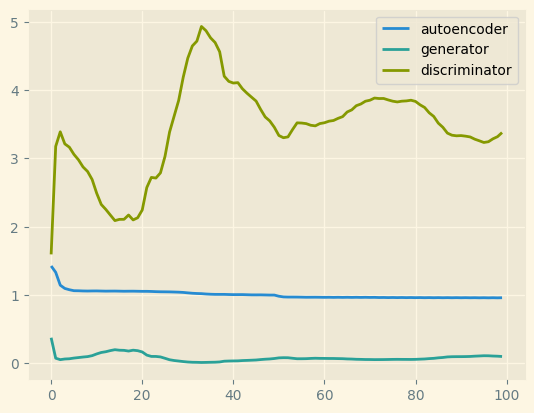

In [27]:
plt.plot(train_autoencoder_loss, label="autoencoder")
plt.plot(train_generator_loss, label="generator")
plt.plot(train_discriminator_loss, label="discriminator")
plt.legend()
plt.show()

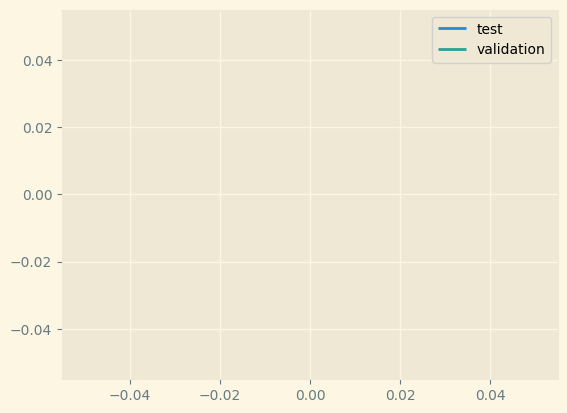

In [34]:
plt.plot(np.mean(test_cost, axis=0), label="test")
plt.plot(np.mean(validation_cost, axis=0), label="validation")
plt.legend()
plt.show()